In [1]:
print("OI")

OI


In computer vision, we normally solve one of the following problems:

* Image Classification is the simplest task, when we need to classify an image into one of many pre-defined categories, for example, distinguish a cat from a dog on a photograph, or recognize a handwritten digit.

* Object Detection is a bit more difficult task, in which we need to find known objects on the picture and localize them, i.e. return the bounding box for each of recognized objects.

* Segmentation is similar to object detection, but instead of giving bounding box we need to return an exact pixel map outlining each of the recognized objects.

![vision.png](Images/vision.png)

## Images as Tensors

Computer Vision works with Images. As you probably know, images consist of pixels, so they can be thought of as a rectangular collection (array) of pixels.

In the first part of this tutorial, we will deal with handwritten digit recognition. We will use the MNIST dataset, which consists of grayscale images of handwritten digits, 28x28 pixels. Each image can be represented as 28x28 array, and elements of this array would denote intensity of corresponding pixel - either in the scale of range 0 to 1 (in which case floating point numbers are used), or 0 to 255 (integers). A popular python library called numpy is often used with computer vision tasks, because it allows to operate with multidimensional arrays effectively.

To deal with color images, we need some way to represent colors. In most cases, we represent each pixel by 3 intensity values, corresponding to Red (R), Green (G) and Blue (B) components. This color encoding is called RGB, and thus color image of size W×H will be represented as an array of size H×W×3 (sometimes the order of components might be different, but the idea is the same).

Multi-dimensional arrays are also called tensors. Using tensors to represent images also has an advantage, because we can use an extra dimension to store a sequence of images. For example, to represent a video fragment consisting of 200 frames with 800x600 dimension, we may use the tensor of size 200x600x800x3.
## TensorFlow and Keras versions


In [2]:
#Import the packages needed.
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

# In this tutorial, we will be training a lot of models. In order to use GPU memory cautiously,
# we will set tensorflow option to grow GPU memory allocation when required.
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

2023-12-28 17:46:12.846820: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-28 17:46:12.878899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 17:46:12.878939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 17:46:12.880161: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 17:46:12.886076: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-28 17:46:12.886930: I tensorflow/core/platform/cpu_feature_guard.cc:1

2.15.0


TensorFlow is now at version 2, and it differs significantly between versions 1 and 2. Thus it is important to check that we have correct version, otherwise the code is likely not to work.

In version 2 TensorFlow added a higher-level neural network construction API called Keras. With Keras, most model building steps can be done in a much simpler way. This has made Keras a preferred way to start training deep learning networks. Only switching to pure TensorFlow when you need to develop some custom architectures for research or more complex scenarios. Since Keras is part of TensorFlow, the terms are used interchangeably and many times when someone says TensorFlow they are actually talking about the Keras.

In this tutorial, we will focused on developing neural networks using Keras in TensorFlow 2.

## Loading the MNIST Dataset

Keras has a [number of datasets](https://www.TensorFlow.org/api_docs/python/tf/keras/datasets) available right from the library. Here we are using the well-known [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits, available through `tf.keras.datasets.mnist`. It has a function `load_data()` that returns train and test MNIST datasets.

When using your own notebooks, you can experiment with the other built in datasets, in particular [FashionMNIST](https://www.TensorFlow.org/api_docs/python/tf/keras/datasets/fashion_mnist). It has exactly the same shape as MNIST, but contains outlines of different clothing types. You should be able to experiment with FashionMNIST by simply replacing the dataset name below.


In [3]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape,y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Visualize the digits dataset
Now that we have downloaded the dataset we can visualize some of the digits

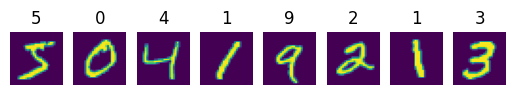

In [10]:
fig, ax = plt.subplots(1, 8)
for i in range(8):
    ax[i].imshow(x_train[i])
    ax[i].set_title(y_train[i])
    ax[i].axis('off')

## Dataset structure

We have a total of 60000 training images (stored in `x_train`) and 10000 testing images (in `x_test`). Labels corresponding to those images are contained in `y_train` and `y_test` accordingly.

In [11]:
print('Training samples:',len(x_train))
print('Test samples:',len(x_test))

print('Tensor size:',x_train[0].shape)
print('First 10 digits are:', y_train[:10])
print('Type of data is ',type(x_train))

Training samples: 60000
Test samples: 10000
Tensor size: (28, 28)
First 10 digits are: [5 0 4 1 9 2 1 3 1 4]
Type of data is  <class 'numpy.ndarray'>


As you can see, the type of data is numpy array, which allows us to manipulate it using any numpy operations. All pixels of the images are represented by integer numbers from 0 to 255:

In [15]:
print('Min intensity value: ',x_train.min())
print('Max intensity value: ',x_train.max())

Min intensity value:  0
Max intensity value:  255
x_train:  784


The reason it is between 0 and 255 is because of how color is represented in a binary format. RGB (red, green, blue) are each represented as a 0-255 value to create digital colors.  If we load any image from file using [OpenCV](https://opencv.org/) or [PIL](https://pillow.readthedocs.io/en/stable/) you will end up having numpy array with pixel intensities in the same range [0..255].

> Note: If you are loading color image, the shape of the array would be slightly different, each pixel contains 3 color values (R,G and B). Thus the image 300x300 pixels will be represented by 300x300x3 numpy array.

If we want to feed our images to the neural network, it is important to make sure that all values are scaled to the range [**0 - 1**] before we start training. So, we will rescale the dataset in order to have all values in the required normalized range:

In [17]:
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

Now we have the data, and we are ready to start training our first neural network!
# Training a dense neural network

The handwritten digit recognition is a classification problem. We will start with the simplest possible approach for image classification - a fully-connected neural network (which is also called a *perceptron*). 

A basic **neural network** consists of a number of **layers**. The simplest network would include just one fully-connected layer, which is called **Dense** layer, with 784 inputs (one input for each pixel of the input image) and 10 outputs (one output for each class). It is called dense because it contains all possible connections between 784 inputs and 10 outputs, 7840 total connections.

As we discussed above, the dimension of our digit images is $28\times28$. Because the input dimension of a fully-connected layer is 784, we need to insert another layer into the network, called **Flatten**, to change tensor shape from $28\times28$ to $784$.

We want $n$-th output of the network to return the probability of the input digit being equal to $n$. Because the output of a fully-connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. To turn it into a probability we need to apply another layer called **Softmax**.


It can be defined in Keras in the following way, using `Sequential` syntax:

In [18]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28,28)), 
        keras.layers.Dense(10,activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Once you have defined a network, you can call the `summary` method to display its architecture and other useful information, such as number of parameters in each layer.

When defining a network, it is important to remember to specify the dimension of the input tensor with the `input_shape` parameter. If you do not do that, Keras is unable to understand how many neurons are required to construct each layer. If `input_shape` is not provided you can still train the network but the summary will be incomplete.

## Anatomy of a Dense Layer

I have mentioned above that a dense layer contains 7840 weighted connections, however, in the `summary` above we see that our dense layer has 7850 parameters. Let's take some time to understand why.

The network input contains 784 pixels, which can be represented by a vector $x$ with 784 numbers. To get an output $z$ of dimension 10 we can multiply it by a matrix $W$ with dimensions $10\times784$: $z=W\times x$.

However, such multiplication defines a linear transformation without shift. Imagine we had only one input value, then the matrix would have just one weight, and the equation $W\times x$ would represent a straight line which goes through the point $(0,0)$. This would not be able to perform arbitrary classifications, because in some cases we also want some **shift** to happen. That means that we need a full equation for a straight line: $z=W\times x + b$, where $b$ is the **bias**.

Similarly, in a dense layer with 784 inputs and 10 outputs, the output would be calculated as $W\times x + b$, where the dimension of **weight** matrix $W$ is $784\times 10$, and the dimension of a **bias** vector $b$ is 10. This gives us $784\times 10 + 10 = 7850$ parameters. 

In Keras, we can get the weight matrix and bias from the `layers` property. Our dense layer is a second layer from the top, thus it can be access using `model.layers[1]`.

In [19]:
model.layers[1].weights

[<tf.Variable 'dense/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[ 0.02771673,  0.07124341,  0.03604512, ..., -0.07525393,
          0.03214808,  0.06448082],
        [ 0.02510791,  0.03972817, -0.08188415, ..., -0.01567601,
         -0.03719572,  0.00884615],
        [ 0.04968324,  0.03552338,  0.06600302, ..., -0.0528735 ,
          0.04655706,  0.04599615],
        ...,
        [ 0.01185407, -0.08641917,  0.0755033 , ..., -0.01635888,
          0.05966324,  0.00244022],
        [-0.03958175,  0.01696643,  0.05801509, ...,  0.02926947,
         -0.03247606, -0.08260639],
        [-0.07358783, -0.01462403, -0.07648194, ...,  0.02595872,
          0.08313813, -0.00667782]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

As you can see, `weights` property of a layer returns a list of all weights, in our case it is the actual weight matrix called **kernel**, and a **bias**.

## Training the network

A network defined this way can take any digit as input and produce a vector of probabilities as an output. Let's see how this network performs by giving it a digit from our dataset:

In [20]:
print('Digit to be predicted: ',y_train[0])
model(np.expand_dims(x_train[0],0))

Digit to be predicted:  5


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.1001831 , 0.09985574, 0.09984273, 0.10026947, 0.09995554,
        0.09983832, 0.10011355, 0.10008995, 0.09981007, 0.10004155]],
      dtype=float32)>

The output of the network is the **tensor**, represented by the `ft.Tensor` object. The tensor type is very similar to a numpy array, however TensorFlow can operate on tensors very efficiently, shifting computations to GPU for better performance.

> **Note**: In fact, low-level TensorFlow API contains all basic tensor operations, similar to corresponding numpy operations on arrays. For example, you can use `tf.exp` on tensors, and it would be equivalent to calling `np.exp` on numpy arrays.

As you can see the network predicts similar probabilities for each digit. This is because it has not been trained on how to recognize the digits yet. We need to give it our training data to train it on our dataset.

To train the model we first need to **compile** it:

In [23]:
model.compile(optimizer='sgd',loss='categorical_crossentropy')

When building a model, we specify two important things:
* An **optimizer** that will be used to minimize the error. The simplest optimizer is **stochastic gradient descent**, or SGD; but with more complex networks other optimizers are often used, such as **Adam**
* A **loss function** will be used on the output of the network to obtain the error, which we will then minimize. For this model we will use **categorical cross-entropy** as the loss function.

To train the network, we need to provide an output for each training sample. We have **multi-class classification** problem since the network outputs probabilities for each digit from 0 to 9 (digits). 

We need the expected outputs to have the same layout, i.e. be a 10-number vector that contains 1 in only one position. This is called **one-hot encoding**. For example, digit 5 will be one-hot-encoded by a vector (0 0 0 0 0 1 0 0 0 0).

We can easily one-hot-encode training labels using Keras API:

In [21]:
y_train_onehot = keras.utils.to_categorical(y_train)
y_test_onehot = keras.utils.to_categorical(y_test)
print("First 3 training labels:",y_train[:3])
print("One-hot-encoded version:\n",y_train_onehot[:3])

First 3 training labels: [5 0 4]
One-hot-encoded version:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now, to do the actual training, we call the `fit` function:

In [24]:
model.fit(x_train,y_train_onehot)

2023-12-28 19:00:44.494385: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 2s 829us/step - loss: 2.3016


## Monitoring training

This training only loops through the dataset once, which is called one **epoch**. Normally we want training to go on for several epochs, and we can specify the number of epochs we want using a parameter.

Also, it is useful to evaluate the quality of the model on test and/or a validation datasets. It's important to test the model with unseen data because this will help indicate how well the model **generalizes** to other data beyond our dataset. To evaluate the error in between epochs, we can pass in validation data:

In [25]:
hist = model.fit(x_train,y_train_onehot,validation_data=(x_test,y_test_onehot), epochs=3)

Epoch 1/3
 128/1875 [=>............................] - ETA: 1s - loss: 2.3004

2023-12-28 19:07:03.483498: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 2s 996us/step - loss: 2.3009 - val_loss: 2.3005
Epoch 2/3
1875/1875 [==============================] - 2s 931us/step - loss: 2.3006 - val_loss: 2.3002
Epoch 3/3
1875/1875 [==============================] - 2s 940us/step - loss: 2.3003 - val_loss: 2.2998


The `fit` function returns the **history** object that contains the loss data for each training epoch. It can be used to visualize the loss on the graph:

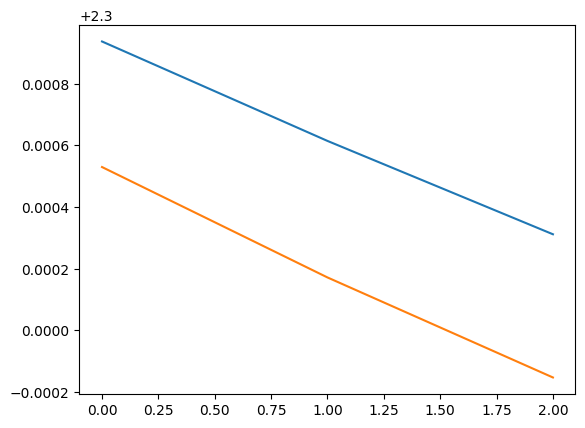

In [27]:
for x in ['loss','val_loss']:
    plt.plot(hist.history[x], label=x)
plt.legend()